In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt
import time

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Classical Conditioning

In [2]:
class Drosophila_RNN(nn.Module):
    def __init__(self, KC_size=200, MBON_size=20, DAN_size=20, FBN_size=60, ext_size=2, out_size=1, net_seed=1234):
        super(Drosophila_RNN, self).__init__()
        # Set the seeds
#         np.random.seed(net_seed)
#         torch.manual_seed(net_seed)
        # Set constants
        self.KC_MBON_min = 0. # Minimum synaptic weight
        self.KC_MBON_max = 0.05 # Maximum synaptic weight
        self.tau_w = 5 # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1 # Time scale of output circuitry activity
        # Set the sizes of layers
        self.N_KC = KC_size
        self.N_MBON = MBON_size
        self.N_FBN = FBN_size
        self.N_DAN = DAN_size
        self.N_recur = MBON_size + FBN_size + DAN_size
        self.N_ext = ext_size
        self.N_out = out_size
        # Define updatable network parameters
#         seed_num = net_seed
        seed_num = None
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_MBON = torch.zeros((self.N_recur, MBON_size))
        mean_FBN = torch.zeros((self.N_recur, FBN_size))
        mean_DAN = torch.zeros((self.N_recur, DAN_size))
        W_MBON = torch.normal(mean_MBON, torch.sqrt(1 / (sqrt2 * MBON_size)), generator=seed_num)
        W_FBN = torch.normal(mean_FBN, torch.sqrt(1 / (sqrt2 * FBN_size)), generator=seed_num)
        W_DAN = torch.normal(mean_DAN, torch.sqrt(1 / (sqrt2 * DAN_size)), generator=seed_num)
        self.W_recur = nn.Parameter(torch.cat((W_MBON, W_FBN, W_DAN), dim=1), requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(FBN_size, ext_size), requires_grad=True)
        mean_readout = torch.zeros((out_size, MBON_size))
        std_readout = 1 / torch.sqrt(torch.tensor(MBON_size, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout, generator=seed_num), requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.N_recur) * 0.1, requires_grad=True)
        self.beta = nn.Parameter(torch.ones(KC_size) * 0.01, requires_grad=True)
        
            
    def forward(self, r_KC, r_ext, time, epoch, W0=None, n_epochs=5000, n_batch=30, nps_bool=True):
        """ Defines the forward pass of the RNN
        
        Synaptic weights from the Keyon cells to the mushroom body output neurons (MBONs) are updated
        dynamically. All other weights are network parameters. The synaptic connections between Keyon
        Cells (KCs) and MBONs are updated using a LTP/LTD rule (see Figure 1B of Jiang 2020), which
        models dopamine-gated neural plasticity on short time scale (behavioural learning). Early
        KC->MBON weight saturation is prevented by a linearly increasing learning rate (see Eq. 12).
        Additionally, non-specific potentiation is included as a form of homeostasis (see Eq. 5).
        
        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Keyon cells (r_KC i.e. 'odors').
        Feedback neurons (FBNs) receive external contextual input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero. DANs receive no external input.

        Inputs
            r_KC = activity of the Kenyon cell neurons (representing odors)
            r_ext = context signals (representing the conditioning context)
            time = time vector for a single interval
            epoch = current training epoch
            W0 = initial weights for KC->MBON connections
            n_epochs = total number of training epochs
            n_batch = number of trials in batch
            nps_bool = boolean indicating whether to include non-specific potentiation

        Returns
            r_recur: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN, N_MBON + N_FBN + N_DAN)
                = time series of KC->MBON weights (represent dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (represents behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        r_init = torch.ones((n_batch, self.N_recur)) * 0.1
        r_init[:, :self.N_MBON] = 0
        r_recur = []
        r_recur.append(r_init)

        # Initialize the eligibility traces and readout
        r_bar_KC = r_KC[:, :, 0]
        r_bar_DAN = r_recur[-1][:, -self.N_DAN:]
        readout = []
        readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(n_batch, 1, 1), r_recur[-1][:, :self.N_MBON])))
        
        # Initialize the dynamic weight variables, accounting for early saturation (see Eq. 12)
        wt = []
        wt.append(torch.zeros((n_batch, self.N_MBON, self.N_KC)))
        W_KC_MBON = []
        W_KC_MBON_0 = torch.ones((n_batch, self.N_MBON, self.N_KC)) * self.KC_MBON_max
        if W0 is None:
            W0 = W_KC_MBON_0
        # Calculate the saturation parameter and modify initial weights
        x_sat = min(1, (epoch / (n_epochs / 2)))
        W0 = (1 - x_sat) * W_KC_MBON_0 + x_sat * W0
        W_KC_MBON.append(W0)

        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        W_recur[:self.N_MBON, -self.N_DAN:] = 0
        
        # Rectify the potentiation parameter
        beta = F.relu(self.beta.clone())
        
        # Update activity for each time step
        for t in range(time.size()[0] - 1):
            # Define the input to the output circuitry
            I_KC_MBON = torch.einsum('bmk, bk -> bm', W_KC_MBON[-1], r_KC[:, :, t])
            I_FBN = torch.einsum('bfe, be -> bf', self.W_ext.repeat(n_batch, 1, 1), r_ext[:, :, t])
            I = torch.zeros((n_batch, self.N_recur))
            I[:, :self.N_MBON] = I_KC_MBON
            I[:, self.N_MBON:self.N_MBON + self.N_FBN] = I_FBN

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs', W_recur.repeat(n_batch, 1, 1), r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(n_batch, 1) + I)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            # Calculate the eligibility traces (represent LTP/LTD)
            r_bar_KC = r_bar_KC + (r_KC[:, :, t] - r_bar_KC) * dt / self.tau_w
            r_bar_DAN = r_bar_DAN + (r_recur[-1][:, -self.N_DAN:] - r_bar_DAN) * dt / self.tau_w
            # Update the dynamic weight variable (see Eq. 5)
            prod1 = torch.einsum('bd, bk -> bdk', r_bar_DAN, r_KC[:, :, t])
            prod2 = torch.einsum('bd, bk -> bdk', r_recur[-1][:, -self.N_DAN:], r_bar_KC)
            # Include non-specific potentiation (unless control condition)
            if nps_bool:
                # Constrain the potentiation parameter to be positive
                prod3 = torch.einsum('bd, bk -> bdk', r_bar_DAN, beta.repeat(n_batch, 1))
            else:
                prod3 = torch.zeros_like(prod2)
            dw = (prod1 - prod2 + prod3)
            wt.append(wt[-1] + dw * dt)
            # Update the KC->MBON weights (see Eq. 8)
            dW = (-W_KC_MBON[-1] + wt[-1]) / self.tau_w
            W_tp1 = W_KC_MBON[-1] + dW * dt
            # Clip the KC->MBON weights to the range [0, 0.05]
            W_KC_MBON.append(torch.clamp(W_tp1, self.KC_MBON_min, self.KC_MBON_max))

            # Calculate the readout (see Eq. 2)
            readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(n_batch, 1, 1), r_recur[-1][:, :self.N_MBON])))

        return r_recur, W_KC_MBON, readout
            
        
# Clipping weights between [0, 0.05]
# https://discuss.pytorch.org/t/how-to-do-constrained-optimization-in-pytorch/60122
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620
# https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933/4

# Setting DAN->MBON weights to zero
# https://pytorch.org/docs/stable/generated/torch.triu.html

# Broadcasting using einsum
# https://github.com/pytorch/pytorch/issues/15671


In [3]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eqs. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [4]:
# Define a training function for first-order conditioning
def train_net(network, T_int=200, T_stim=2, dt=0.5, n_epochs=5000, n_batch=30, clip=0.001, train=True, nps=True):
    """ Trains a network on a continual learning task.
    
    Task includes repetitive presentation of four stimuli (two CS+ and two CS-) per trial.
    The presentation times of each stimulus are drawn from a Poisson process, and the inputs
    are generated by a function. The dopamine gated plasticity has an additional non-specific
    potentiation factor (see Eq. 5 of Jiang 2020), which is included in the forward() function.
    KC->MBON weights are set once at the beginning of optimization, and then continue forward
    between each successive trial (see p14 of Jiang 2020).
    
    Parameters
        network = RNN network to be trained or ran
        T_int = length of task intervals (eg conditioning, test, extinction)
        T_stim = length of time each stimulus is presented
        dt = time step of simulations
        n_epochs = number of epochs to train over
        n_batch = number of trials in mini-batch
        clip = maximum gradient allowed during training
        train = boolean indicating whether to perform backprop
        nps = boolean indicating whether to include non-specific potentiation
        
    Returns
        r_out_epoch = output circuit neuron activities for final epoch
        Wt_epoch = KC->MBON weights for final epoch
        vt_epoch = readout (i.e. valence) for final epoch
        vt_opt = target valence for final epoch
        loss_hist = list of losses for all epochs
        ls_stims = list of stimulus time series for plotting
    """
    
    # Interval time vector
    time_int = torch.arange(0, T_int + dt/10, dt)

    # Neuron population sizes
    n_KC = network.N_KC
    n_ext = network.N_ext
    n_MBON = network.N_MBON
    # Set the intial KC->MBON weight values
    W_KC_MBON = torch.ones((n_batch, n_MBON, n_KC)) * network.KC_MBON_max

    # List to store losses
    loss_hist = []

    for epoch in range(n_epochs):
        # Generate the odor (r_KC) and context (r_ext) inputs, and target valence (vt_opt)
        r_KC, r_ext, vt_opt, ls_stims = continual_inputs(T_int, T_stim, dt, n_KC, n_ext, n_batch)

        # Run the forward model
        r_outs, Wts, vts = network(r_KC, r_ext, time_int, epoch, W_KC_MBON, n_epochs, n_batch, nps)
        # Set the initial KC->MBON weights for the next trial
        W_KC_MBON = Wts[-1].detach()

        # Concatenate the activities, weights and valences
        r_out_epoch = torch.stack(r_outs, dim=-1)
        Wt_epoch = torch.stack(Wts, dim=-1)
        vt_epoch = torch.stack(vts, dim=-1)

        # Calculate the loss
        loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -classic_net.N_DAN:, :])

        if train:
            # Update the network parameters
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classic_net.parameters(), clip)
            optimizer.step()

        # Print an update
        if epoch % 500 == 0:
            print(epoch, loss.item())
        loss_hist.append(loss.item())

    return r_out_epoch, Wt_epoch, vt_epoch, vt_opt, loss_hist, ls_stims

# https://discuss.pytorch.org/t/proper-way-to-do-gradient-clipping/191/13
# https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48
# https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961


In [5]:
# Define functions for each of the conditioning tasks
# Some detail provided in Jiang 2020 -> Methods -> Continual learning
# def continual_inputs(stim_times, stim_len, time_len, CS_odors, n_KC, n_ext, n_batch, plot=None):
# def continual_inputs(stim_times, stim_len, time_len, n_KC, n_ext, n_batch, plot=None):
def continual_inputs(T_int, T_stim, dt, n_KC, n_ext, n_batch):
    """ Generates inputs for continual learning task.
    
    All trials are composed of Poisson distributed presentations of two CS+ and two CS- (US omitted)
    stimuli. CS+ are presented with a US in all cases (target valence set for CS+ after first
    presentation). To account for the sequential nature of numerical simulations, the target valence
    is set to begin one time step after stimulus onset.
    
    Parameters
        T_int = length of task interval
        T_stim = length of time each stimulus is presented
        dt = time step of simulations
        CS_odors = list of two CS+ and two CS- stimuli for each trial in batch
        n_KC = number of Kenyon cell input neurons
        n_ext = number of contextual input neurons
        n_batch = number of trials in mini-batch
        plot = used when plot function is called, indicates which task to plot
        
    Returns
        r_KCt = list of odor (KC) input time series arrays for each interval
        r_extt = list of context (ext) input time series arrays for each interval
        vt_opt = time series of target valence for plotting and loss calculations
        ls_stims = list of stimulus time series for plotting
    """
    
    # Number of odors in trial
    n_odors = 4
    # Number of active neurons in an odor
    n_ones = int(n_KC * 0.1)
    # Poisson rate of stimulus presentations
    stim_rate = 2 / T_int
    # Length of stimulus in indices
    stim_len = int(T_stim / dt)
    # Length of trial in indices
    time_len = int(T_int / dt + 1)
    
    # Initialize activity matrices
    r_KCt = torch.zeros(n_batch, n_KC, time_len)
    r_extt = torch.zeros(n_batch, n_ext, time_len)
    
    # Initialize lists and arrays to store stimulus time series
    ls_CS = []
    time_US_all = torch.zeros(n_batch, time_len)
    vt_opt = torch.zeros(n_batch, time_len)
    
    # For each batch, randomly generate different odors and presentation times
    for i in range(n_odors):
        # Initialize the CS time matrix
        time_CS = torch.zeros(n_batch, time_len)
        time_US = torch.zeros_like(time_CS)

        # Conditioned stimuli (CS) = odors
        r_KC = torch.zeros(n_batch, n_KC)
        # Unconditioned stimuli (US) = context
        r_ext = torch.multinomial(torch.ones(n_batch, n_ext), n_ext)
            
        # For each trial
        for b in range(n_batch):
            # Define an odor (CS)
            r_KC_inds = torch.multinomial(torch.ones(n_KC), n_ones)
            r_KC[b, r_KC_inds] = 1

            # Generate a list of stimulus presentation times
            stim_times = []
            last_time = 0
            while True:
                stim_isi = -torch.log(torch.rand(1)) / stim_rate
                next_time = last_time + stim_isi
                if next_time < (T_int - 2 * T_stim):
                    # Stimulus times are indices (not times)
                    stim_times.append((next_time / dt).int())
                    last_time += stim_isi
                # Ensure at least one presentation of each stimuli
                elif last_time == 0:
                    continue
                else:
                    break
                    
            for j, st in enumerate(stim_times):
                # Set the CS input times
                stim_inds = st + torch.arange(stim_len)
                time_CS[b, stim_inds] = 1

                # For CS+ odors, set US and the valence
                if i < 2:
                    # Set the US input times
                    time_US[b, (stim_inds + stim_len)] = 1
                    # Set a target valence on every presentation but the first
                    if j > 0:
                        if r_ext[b, 0] == 1:
                            vt_opt[b, (stim_inds + 1)] = 1
                        else:
                            vt_opt[b, (stim_inds + 1)] = -1

        # Calculate the stimulus time series (KC = CS, ext = US)
        r_KCt += torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
        r_extt += torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
        ls_CS += time_CS
        time_US_all += time_US
        
    # Make a list of stimulus times to plot
    ls_stims = ls_CS + [time_US_all]
        
    return r_KCt, r_extt, vt_opt, ls_stims
    

In [36]:
def print_trial(network, dt=0.5, nps=True):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        dt = time step of the simulation/plot
        nps = boolean indicating whether to include non-specific potentiation
    """
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, Wt, vt, vt_opt, loss_hist, stim_ls = train_net(network, dt=dt, n_epochs=1, n_batch=1, train=False, nps=nps)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_US = stim_ls[-1].numpy().squeeze()
    plot_time = np.arange(plot_US.size) * dt

    # Plot the conditioning and test
    CS_labels = ['CS1+', 'CS2+', 'CS1-', 'CS2-']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    for i in range(len(stim_ls) - 1):
        plot_CS = stim_ls[i].numpy().squeeze()
        ax1.plot(plot_time, plot_CS, label=CS_labels[i])
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title('Continual Learning', fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.N_MBON, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [7]:
# Initialize the network
classic_net = Drosophila_RNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])
torch.Size([200])


In [8]:
train_bool = True
if train_bool:
    r_out, Wt, vt, vt_opt, loss_hist, _ = train_net(classic_net)


0 11.624919891357422
500 0.004618396982550621
1000 0.002697988646104932
1500 0.005810739938169718
2000 0.002204367658123374
2500 0.0028249730821698904
3000 0.0034405519254505634
3500 0.0016178966034203768
4000 0.0022972782608121634
4500 0.0032483458053320646


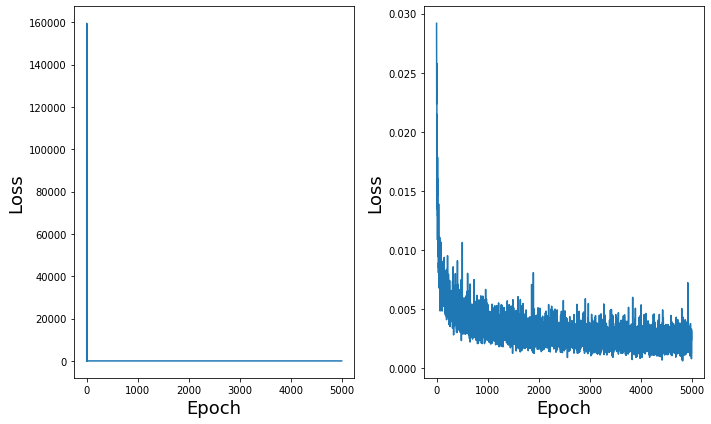

In [9]:
# Plot the loss function
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_hist)
axes[0].set_xlabel('Epoch', fontsize=label_font)
axes[0].set_ylabel('Loss', fontsize=label_font)
axes[1].plot(loss_hist[5:])
axes[1].set_xlabel('Epoch', fontsize=label_font)
axes[1].set_ylabel('Loss', fontsize=label_font)
fig.tight_layout();


In [37]:
torch.save(classic_net.state_dict(), 'trained_N7_continual.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


0 0.002469112863764167


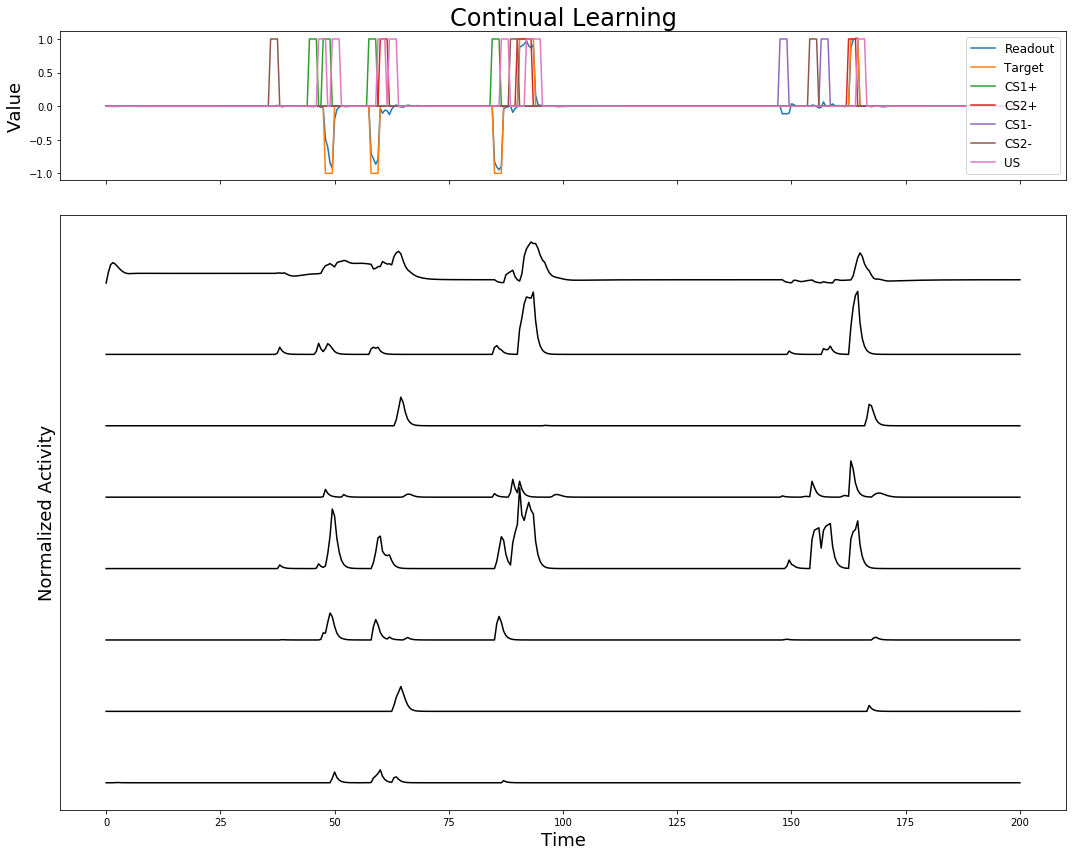

In [41]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
#     classic_net.load_state_dict(torch.load('trained_N7_continual.pt'))
    classic_net.eval()

print_trial(classic_net)
